In [1]:
# 1 导入需要的库

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  
import albumentations as AL   # pip install albumentations==1.1.0  
from albumentations.pytorch import ToTensorV2  
import torchvision  
from torchvision import datasets,transforms  
from tqdm import tqdm  
import cv2  
from torch.utils.data import Dataset,DataLoader  
import torch.optim as optim  
from PIL import Image  
import os  
import torch.nn.functional as F  
import ast

In [2]:
# 2 定义参数  
LR = 1e-4  
SPLIT = 0.2  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  
BATCH_SIZE = 4  
EPOCHS = 2  
DATAPATH = './'

In [3]:
# 3  读取数据

# 读取 train.csv文件  
df = pd.read_csv(DATAPATH + '/train.csv')  
df.bbox = df.bbox.apply(ast.literal_eval)   #  字符串列表转列表 
  
# 利用groupby 将同一个image_id的数据进行聚合，在同一list，并且用reset_index直接转变成dataframe  
df = df.groupby("image_id")["bbox"].apply(list).reset_index(name="bboxes") 


# 4  划分数据
def train_test_split(dataFrame,split):  
    len_tot = len(dataFrame)  
    val_len = int(split*len_tot)  
    train_len = len_tot-val_len  
    train_data,val_data = dataFrame.iloc[:train_len][:],dataFrame.iloc[train_len:][:]  
    return train_data,val_data  


# print(len(df))    
train_data_df,val_data_df = train_test_split(df,SPLIT)  # 划分 train val 8:2  
# print(len(train_data_df), len(val_data_df))  

In [5]:
train_data_df.head(2)

,image_id,bboxes
0,00333207f,"[[0, 654, 37, 111], [0, 817, 135, 98], [0, 192..."
1,005b0d8bb,"[[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15..."


In [6]:
# 5 定义WheatDataset 返回 图片，标签  
class WheatDataset(Dataset):  
    def __init__(self,data,root_dir,transform=None,train=True):  
        self.data = data  
        self.root_dir = root_dir  
        self.image_names = self.data.image_id.values  
        self.bboxes = self.data.bboxes.values  
        self.transform = transform  
        self.isTrain = train  
    def __len__(self):  
        return len(self.data)  
    def __getitem__(self,index):  
#         print(self.image_names)  
#         print(self.bboxes)  
        img_path = os.path.join(self.root_dir,self.image_names[index]+".jpg")  # 拼接路径  
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)   # 读取图片  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)  # BGR2RGB  
        image /= 255.0    # 归一化  
        bboxes = torch.tensor(self.bboxes[index],dtype=torch.float64)  
#         print(bboxes)  
        
        bboxes[:,2] = bboxes[:,0]+bboxes[:,2]   # 格式转换 (xmin,ymin,width,height)-----> (xmin,ymin,xmax,ymax)  
        bboxes[:,3] = bboxes[:,1]+bboxes[:,3]  
#         print(image.size,type(image))  
        """  
            we need to return image and a target dictionary  
            target:  
                boxes,labels,image_id,area,iscrowd  
        """  
        area = (bboxes[:,3]-bboxes[:,1])*(bboxes[:,2]-bboxes[:,0])   # 计算面积  
        area = torch.as_tensor(area,dtype=torch.float32)  
          
        # there is only one class  
        labels = torch.ones((len(bboxes),),dtype=torch.int64)   # 标签  
          
        # suppose all instances are not crowded  
        iscrowd = torch.zeros((len(bboxes),),dtype=torch.int64)  
          
        target = {}   # target是个字典 里面 包括 boxes,labels,image_id,area,iscrowd  
        target['boxes'] = bboxes  
        target['labels']= labels  
        target['image_id'] = torch.tensor([index])  
        target["area"] = area  
        target['iscrowd'] = iscrowd  
          
        if self.transform is not None:  
            sample = {  
                'image': image,  
                'bboxes': target['boxes'],  
                'labels': labels  
            }  
            sample = self.transform(**sample)  
            image = sample['image']  
              
            # 沿着一个新维度对输入张量序列进行连接。 序列中所有的张量都应该为相同形状，   
#             把多个2维的张量凑成一个3维的张量；多个3维的凑成一个4维的张量…以此类推，也就是在增加新的维度进行堆叠  
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)  
              
        return image,target  

In [7]:
# 6 数据增强  利用albumentations  随机翻转转换，随机图片处理  张量转换  读取格式
# 对象检测的增强与正常增强不同，因为在这里需要确保 bbox 在转换后仍然正确与对象对齐  
train_transform = AL.Compose([  AL.Flip(0.5),  ToTensorV2(p=1.0)  ],bbox_params = {'format':"pascal_voc",'label_fields': ['labels']})  
val_transform = AL.Compose([  ToTensorV2(p=1.0)  ],bbox_params = {'format':"pascal_voc","label_fields":['labels']})  

#7 数据整理
 
"""  
collate_fn默认是对数据图片通过torch.stack()进行简单的拼接。对于分类网络来说，默认方法是可以的（因为传入的就是数据的图片），  
但是对于目标检测来说train_dataset返回的是一个tuple,即(image, target)。  
如果我们还是采用默认的合并方法，那么就会出错。  
所以我们需要自定义一个方法即collate_fn=train_dataset.collate_fn  
"""  
def collate_fn(batch):  
    return tuple(zip(*batch))  

#8 创建数据

train_data = WheatDataset(train_data_df,DATAPATH+"/train",transform=train_transform)  
valid_data = WheatDataset(val_data_df,DATAPATH+"/train",transform=val_transform)  


torch.Size([3, 1024, 1024])


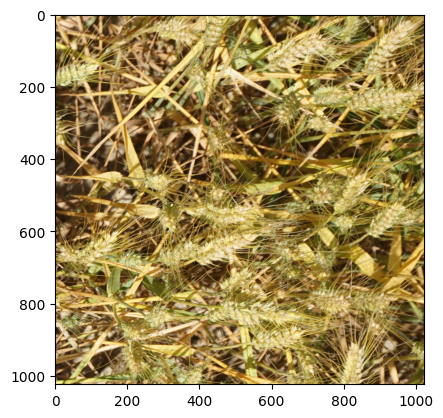

In [8]:
# 9 查看一个训练集中的数据  
image,target = train_data.__getitem__(0)  
plt.imshow(image.numpy().transpose(1,2,0))  
print(image.shape)  

In [9]:
# 10 定义模型
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  
  
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)  
num_classes = 2  
in_features = model.roi_heads.box_predictor.cls_score.in_features  
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)  

c:\users\m1409\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\m1409\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# 11 定义Averager类  保存对应的loss  
class Averager:  
    def __init__(self):  
        self.current_total = 0.0  
        self.iterations = 0.0  
  
    def send(self, value):  
        self.current_total += value  
        self.iterations += 1  
  
    @property  
    def value(self):  
        if self.iterations == 0:  
            return 0  
        else:  
            return 1.0 * self.current_total / self.iterations  
  
    def reset(self):  
        self.current_total = 0.0  
        self.iterations = 0.0  

#12 构建训练和测试 dataloader
 
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)  
val_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [ ]:
# 13 定义模型参数 优化器，损失， 迭代，以及 学习率  
train_loss = []  
# val_loss = []  
model = model.to(DEVICE)  
params =[p for p in model.parameters() if p.requires_grad]  
optimizer = optim.Adam(params,lr=LR)  
loss_hist = Averager()  
itr = 1  
lr_scheduler=None  
  

#14 模型训练
if __name__ == '__main__':  
  
    for epoch in range(EPOCHS):  
        loss_hist.reset()  
  
        for images, targets in train_dataloader:  
  
            # print(images)  
            # print(targets)  
  
            # for image in images:  
            #     print(image.dtype)  # torch.float32  
  
            # for t in targets:  
            #     for k, v in t.items():  
            #         print(k ,v.dtype)  
  
            images = list(image.to(DEVICE) for image in images)  
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]  
  
  
            loss_dict = model(images, targets)  
  
            # for loss in loss_dict.values():  
            #     print(loss.dtype)  
  
            losses = sum(loss for loss in loss_dict.values())  
            loss_value = losses.item()  
  
            loss_hist.send(loss_value)  
  
            optimizer.zero_grad()  
            losses.backward()  
            optimizer.step()  
  
            if itr % 50 == 0:  
                print(f"Iteration #{itr} loss: {loss_value}")  
  
            itr += 1  
  
        # update the learning rate  
        if lr_scheduler is not None:  
            lr_scheduler.step()  
  
        print(f"Epoch #{epoch} loss: {loss_hist.value}")  


# 15  模型保存  
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')  

Iteration #50 loss: 1.24800759545934
Iteration #100 loss: 1.060296238573247
Iteration #150 loss: 0.8301578374266533
Iteration #200 loss: 0.8446484321360798
Iteration #250 loss: 0.8145344598720824
Iteration #300 loss: 0.9003189740954384
Iteration #350 loss: 0.8663028621771596
Iteration #400 loss: 0.8710817814216558
Iteration #450 loss: 1.0270811382733336
Iteration #500 loss: 0.9516785138037778
Iteration #550 loss: 0.8570117906719339
Iteration #600 loss: 1.0178128140871605
Iteration #650 loss: 0.8396488044262588
Epoch #0 loss: 0.9131021489132024
Iteration #700 loss: 0.8488655353849005
Iteration #750 loss: 0.8560079412730078
Iteration #800 loss: 0.8523659518818513
Iteration #850 loss: 0.7611081852038186
Iteration #900 loss: 0.8174310394465027
